# Rapidly-exploring Random Trees (RRT)
Chiếc code này sẽ demo cho các bạn thấy cách để tạo ra hệ thống RRT đơn giản cho riêng bạn.

## Các giá trị đầu vào và đầu ra của RRT
**Đầu vào**: 
* Điểm bắt đầu $x_0$
* Tập hợp các điểm kết thúc $X_{goal}$
* Tập hợp các chướng ngại vật $X_{obs}$
* Khoảng cách cho phép lớn nhất giữa những điểm trên bản đồ $d_{max}$

**Đầu ra**: 
* Tập hợp các đường có thể đi đến đích $\mathcal{N}$

## Cách RRT chạy
**Khởi tạo node đầu tiên $n_0$ và các biến số của RRT**: 
* $n_0.x \leftarrow x_0$
* $n_0.parent \leftarrow \emptyset$
* $n_0.index \leftarrow 0$
* $\mathcal{N} \leftarrow \{n_0\}$
* $k \leftarrow 1$

**Chạy vòng lặp tạo cây cho RRT:**

* **Cho đến khi** $n_k.x \notin X_{goal}$:
    * Chọn 1 điểm ngẫu nhiên $x_{random}$
    * Tìm node $n_{nearest} \in \mathcal{N}$ giảm thiểu giá trị $\|n.x - x_{random}\|_2$
    * $x_{new} \leftarrow Steer(x_{nearest}, x_{random}, d_{max})$
    * **Nếu** $\neg IsCollision(x_{new},x_{nearest},X_{obs})$ **thì**:
        * $n_k.x \leftarrow x_{new}$
        * $n_k.parent \leftarrow n_{nearest}.index$
        * $n_k.index \leftarrow k$
        * $k \leftarrow k+1$
    
Theo cấu trúc code bên trên, ta thấy có 2 hàm được sử dụng là **Steer** và **IsCollision**. 
* Hàm **Steer** giúp chúng ta quyết định xem có nên tiếp tục sử dụng $x_{random}$ làm $x_{new}$ không hay nên tiếp tục lựa chọn $x_{random}$ đến khi tìm được điểm **đủ gần** với chúng ta để đi đến.
* Hàm **IsCollision** kiểm tra giúp chúng ta xem đường thẳng nối từ $x_{nearest}$ sang $x_{new}$ có phạm vào chướng ngại vật không.

Mặc khác, để tạo ra các **cây** trong RRT, chúng ta lưu lại tập hợp những **node** trong cây. Để có thể từ các **node** mà tạo ra cây, mỗi **node** có những thông tin sau:
* Toạ độ của node trong bản đồ, gọi là **x**
* Thứ tự của node được tìm thấy xuyên suốt quá trình quét bản đồ, gọi là **index**
* Điểm node liền kề trước đó của node này, gọi là **parent**

Từ đây ta có thể thấy, giả sử RRT đã tìm ra được node $n_k$ có $n_k.x \in X_{goal}$, chúng ta chỉ cần dựa vào **parent** của node này để kiếm node trước đó, rồi lại tiếp tục từ **parent** của node trước đó đi ngược về node trước đó nữa, từ từ đến khi chúng ta quay về được $n_0$, thì tập hợp con này sẽ chính là quãng đường đi từ $n_0$ đến $X_{goal}$ mà không đụng chướng ngại vật.

## Bài toán thực tế
Giả sử chúng ta có 1 con robot tại toạ độ $x_0 = (0,0)$. Robot này có nhiệm vụ đi đến 1 vùng đích đến hình tròn có công thức $x_{goal} = \{x \in \mathbb{R}^2:\|x-(90,25)\|_2 \le 2\}$. Mặc khác, trong suốt quá trình di chuyển, robot sẽ không được đụng trúng những chướng ngại vật ở những vị trí sau:

* $x_{obs}^1 = \{x \in \mathbb{R}^2: 20 \le x_1 \le 40, 10 \le x_2 \le 20 \}$
* $x_{obs}^2 = \{x \in \mathbb{R}^2: 50 \le x_1 \le 70, 15 \le x_2 \le 35 \}$
* $x_{obs}^3 = \{x \in \mathbb{R}^2: 80 \le x_1 \le 81, 5 \le x_2 \le 30 \}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Viết 1 hàm **Steer** để tính toán $x_{new}$ bằng cách di chuyển từ $x_{nearest}$ đến 1 điểm ngẫu nhiên trên bản đồ, gọi là $x_{random}$, trên 1 đường thẳng có độ dài tối đa $d_{max}$

In [2]:
def steer(x_nearest, x_random, d_max):
    # distance between x_random and x_nearest
    v = x_random - x_nearest
    distance = np.sqrt(v.T @ v)
    if distance > d_max:
        u = (x_random - x_nearest) / (v.T @ v)
        return x_nearest + u * d_max
    else:
        return x_random
    return 0

Kiểm tra đoạn code vừa viết với 2 bài test đơn giản sau

In [3]:
# report test case
# a. x_random = (96, 46), x_nearest = (39.20, 22.41), d_max = 1
x_random = np.array([96, 46])
x_nearest = np.array([39.20, 22.41])
d_max = 1
x_new = steer(x_nearest, x_random, d_max)
print(x_new)

# b. x_random = (23, 32), x_nearest = (32, 23), d_max = 15
x_random = np.array([23, 32])
x_nearest = np.array([32, 23])
d_max = 15
x_new = steer(x_nearest, x_random, d_max)
print(x_new)

[39.21501562 22.41623624]
[23 32]


Tạo **class Obstacle** tượng trưng cho các thông tin cần có của 1 khối hộp chướng ngại vật trên bản đồ. Chúng ta cũng sẽ viết 1 hàm **IsCollision** đơn giản để kiểm tra xem liệu 1 toạ độ nào đó có nằm trong chướng ngại vật không

In [4]:
class Obstacle:
    def __init__(self, x_min, x_max, y_min, y_max):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
    
    def in_range_x(self, x):
        if x <= self.x_max and x >= self.x_min:
            return True
        else:
            return False
        
    def in_range_y(self, y):
        if y <= self.y_max and y >= self.y_min:
            return True
        else:
            return False
        
def isCollision(x_new, x_obs):
    for obs in x_obs:
        if obs.in_range_x(x_new[0]) and obs.in_range_y(x_new[1]):
            return True
        else:
            continue
    return False

Kiểm tra hàm đã viết với 2 test case đơn giản. Nếu toạ độ x, y của điểm thuộc vùng toạ độ của chướng ngại vật, thì **IsCollision** sẽ trả về **True** và ngược lại

In [5]:
# report test case on collision
# a. x_new = (39, 22.2), x_obs = {20 <= x <= 35, 25 <= y <= 40}
x_obs = Obstacle(20, 35, 25, 40)
x_new = np.array([39, 22.2])
print(isCollision(x_new, [x_obs]))

# b. x_new = (6.8, 1.2), x_obs = {15 <= x1 <= 45, 5 <= y <= 20} + {5 <= x1 <= 12, 0.8 <= y <= 1.5}
x_new = np.array([6.8, 1.2])
x_obs_1 = Obstacle(15, 45, 5, 20)
x_obs_2 = Obstacle(5, 12, 0.8, 1.5)
print(isCollision(x_new, [x_obs_1, x_obs_2]))

False
True


Hàm **IsCollision** mà ta đã viết chỉ quan tâm xem liệu 1 điểm có nằm ở trong vùng chướng ngại vật không. Nhưng liệu nếu 2 điểm ta đang xét ($x_{new}$ và $x_{nearest}$) không nằm trong vùng chướng ngại vật, nhưng **đường thẳng nối giữa 2 điểm này lại cắt khối hộp chướng ngại vật** thì robot sẽ vẫn va vào chướng ngại vật khi đi theo con đường này. Ta cần phải sửa **IsCollision** để kiểm tra xem liệu đoạn thẳng nối giữa 2 điểm có cắt khối hộp không 

In [6]:
# new isCollision() function
# A Python3 program to find if 2 given line segments intersect or not
# Source: https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/
 
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
 
# Given three collinear points p, q, r, the function checks if
# point q lies on line segment 'pr'
def onSegment(p, q, r):
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))):
        return True
    return False
 
def orientation(p, q, r):
    # to find the orientation of an ordered triplet (p,q,r)
    # function returns the following values:
    # 0 : Collinear points
    # 1 : Clockwise points
    # 2 : Counterclockwise
     
    # See https://www.geeksforgeeks.org/orientation-3-ordered-points/amp/
    # for details of below formula.
     
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y))
    if (val > 0):
        # Clockwise orientation
        return 1
    elif (val < 0):
        # Counterclockwise orientation
        return 2
    else:
        # Collinear orientation
        return 0
 
# The main function that returns true if
# the line segment 'p1q1' and 'p2q2' intersect.
def doIntersect(p1, q1, p2, q2):
     
    # Find the 4 orientations required for
    # the general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)
 
    # General case
    if ((o1 != o2) and (o3 != o4)):
        return True
 
    # Special Cases 
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1
    if ((o1 == 0) and onSegment(p1, p2, q1)):
        return True
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1
    if ((o2 == 0) and onSegment(p1, q2, q1)):
        return True
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2
    if ((o3 == 0) and onSegment(p2, p1, q2)):
        return True
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2
    if ((o4 == 0) and onSegment(p2, q1, q2)):
        return True
    # If none of the cases
    return False

def isCollisionNew(x_new, x_nearest, x_obs):
    for obs in x_obs:
        # the four corners of each obs
        # C2 +-----------------+ C4
        #    |                 |
        #    |                 |
        # C1 +-----------------+ C3
        C1 = Point(obs.x_min, obs.y_min)
        C2 = Point(obs.x_min, obs.y_max)
        C3 = Point(obs.x_max, obs.y_min)
        C4 = Point(obs.x_max, obs.y_max)
        
        # find collision between the line segment created by x_new and x_nearest with Ci and Cj (the four sides of rectangle)
        if doIntersect(Point(x_new[0], x_new[1]), Point(x_nearest[0], x_nearest[1]), C1, C2):
            return True
        if doIntersect(Point(x_new[0], x_new[1]), Point(x_nearest[0], x_nearest[1]), C2, C4):
            return True
        if doIntersect(Point(x_new[0], x_new[1]), Point(x_nearest[0], x_nearest[1]), C4, C3):
            return True
        if doIntersect(Point(x_new[0], x_new[1]), Point(x_nearest[0], x_nearest[1]), C1, C3):
            return True
    return False

In [7]:
# test case: obs = {3 <= x <=8, 1 <= y <= 4}
# collision: x_nearest = (2, 3), x_new = (5, 0)
print(isCollisionNew(np.array([2, 3]), np.array([5, 0]), [Obstacle(3, 8, 1, 4)]))

# no collision: x_nearest = (2, 5), x_new = (6, 5)
print(isCollisionNew(np.array([2, 5]), np.array([6, 5]), [Obstacle(3, 8, 1, 4)]))

True
False


Viết các hàm còn lại hỗ trợ cho RRT, bao gồm class **Node** với các thông tin cần thiết của 1 node, **isAtGoal** để kiểm tra xem robot đã đến goal chưa, và **rrt_algorithm** theo pseudo code ở trên cho RRT.

In [8]:
class Node:
    def __init__(self, x, parent, index):
        self.x = x
        self.parent = parent
        self.index = index
        
def isAtGoal(x, x_goal, radius = 2):
    # check if x is within the goal region, which is a circle in the form:
    # || x - x_goal || <= radius
    if (x - x_goal).T @ (x - x_goal) <= radius ** 2:
        return True
    return False

def rrt_algorithm(x0, x_goal, x_obs, d_max):
    import time
    # initialize
    N = []
    n = Node(x0, -1, 0)
    N.append(n)
    k = 1
    
    max_x = 100
    max_y = 50
    
    # start running
    while not isAtGoal(n.x, x_goal):
        x_random = np.random.rand(2) * [max_x, max_y]
        tree = [n.x for n in N]
        x_nearest_index = np.diag((tree - x_random) @ (tree - x_random).T).argmin()
        x_nearest = N[x_nearest_index]
        x_new = steer(x_nearest.x, x_random, d_max)
        if not isCollisionNew(x_new, x_nearest.x, x_obs):
            n = Node(x_new, x_nearest.index, k)
            k = k + 1
            N.append(n)
    return N

Tạo các chướng ngại vật theo đề bài

In [9]:
x_obs = [
    Obstacle(20, 40, 10, 20),
    Obstacle(50, 70, 15, 35),
    Obstacle(80, 81, 5, 30)
]

Chạy RRT với goal tại (90, 25), điểm xuất phát (0, 0) và max d = 5

In [10]:
N = rrt_algorithm(np.array([0, 0]), np.array([90, 25]), x_obs, 5)

Sau khi ta đã có tập hợp N của các điểm node, ta sẽ từ điểm node cuối cùng, đi ngược lại về điểm bắt đầu dựa vào giá trị **parent** của từng node để tạo thành 1 con đường nối từ điểm bắt đầu đến goal

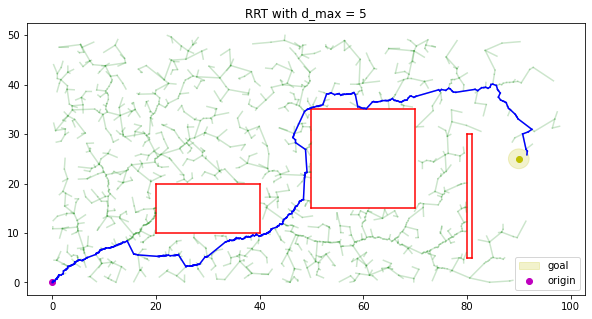

In [11]:
# trace from last point of tree to reconstruct path
success_path = []
goal_index = N[-1].index
parent_index = N[goal_index].parent
success_path.append(goal_index)
success_path.append(parent_index)

while True:
    parent_index = N[parent_index].parent
    if parent_index == -1:
        break
    success_path.append(parent_index)

plt.figure(figsize = (10, 5))
for obs in x_obs:
    plt.plot([obs.x_min, obs.x_max], [obs.y_min, obs.y_min], 'r')
    plt.plot([obs.x_min, obs.x_max], [obs.y_max, obs.y_max], 'r')
    plt.plot([obs.x_min, obs.x_min], [obs.y_min, obs.y_max], 'r')
    plt.plot([obs.x_max, obs.x_max], [obs.y_min, obs.y_max], 'r')
    
for n in N[1:]:
    parent = N[n.parent]
    plt.plot([n.x[0], parent.x[0]], [n.x[1], parent.x[1]], 'g', alpha = 0.2)
    
for i in range(len(success_path) - 1):
    x0 = N[success_path[i]].x
    x1 = N[success_path[i+1]].x
    plt.plot([x0[0], x1[0]], [x0[1], x1[1]], 'b')
    
goal = plt.Circle((90, 25), 2.0, color = 'y', label = "goal", alpha = 0.2)
plt.title("RRT with d_max = 5")
plt.scatter(90, 25, color = "y")
plt.scatter(0, 0, color = "m", label = "origin")
plt.gca().add_patch(goal)
plt.legend()
plt.show()

Bạn có thể thay đổi giá trị d_max để thấy được RRT hoạt động như thế nào. Lưu ý nếu d_max quá nhỏ, RRT sẽ chạy rất lâu nha..